# Lectura de datos

# Training

Acá se toma la data del respositorio de S3 en donde se dejan las queries de Athena, para que sea más eficiente la perfrmance de traer los datos. Se va a modelizar con las cosechas de campañas desde 201804 a 201811. Por lo tanto la data que se necesita de las tablas de cliente mes iran desde 201802 hasta 201809 y las variables que vengan de RCC van desde 201801 a 201808. La variable respuesta por ahora se sacó de una tabla externa que construimos al momento del modelo.

In [33]:
import boto3
from pyathena import connect
from pyathena.util import as_pandas
import numpy as np
import pandas as pd 

client = boto3.client('s3') 

obj= client.get_object(Bucket='sftp-analytics-stg-transferbucket-a3e4afdvn23', Key='data/output/Unsaved/2019/08/23/256eede0-7c18-459f-80ff-36fb27a256a0.csv')
X= pd.read_csv(obj['Body'])


X = X.apply(pd.to_numeric, errors='coerce')

numerics=["int16", "int32", "int64", "float16", "float32", "float64"]
X=X.select_dtypes(include=numerics)
X = X.drop(["flg_venta", "flg_incremento"],axis=1)
#            "flg_Venta_ing", "flg_Campania_ing", "parquetarcred_ing", "pa_ing",
#           "segmentomercado_ing", "Tend_ingresobruto_ing", "segmento_ant_ing", "codempresa_tc_princ_ing", "codsbs_ing"],axis=1)

X[np.isnan(X)] = 0

X_modelo = X[(X['codmes'] == 201804) | (X['codmes'] == 201806) | (X['codmes'] == 201808) |  (X['codmes'] == 201809) | (X['codmes'] == 201810) | (X['codmes'] == 201904) | (X['codmes'] == 201902)]

X_backtest = X[(X['codmes'] == 201805) | (X['codmes'] == 201807) | (X['codmes'] == 201811 ) | (X['codmes'] == 201901 ) | (X['codmes'] == 201903 )]

In [34]:
X_modelo.groupby(['codmes','flg_target']).count()[['key_value']]


key_value
codmes flg_target           
201804 0.0             80880
       1.0              9952
201806 0.0             87625
       1.0             11163
201808 0.0             85385
       1.0             14291
201809 0.0             90004
       1.0             12810
201810 0.0             97665
       1.0             13608
201902 0.0            136664
       1.0             10653
201904 0.0            183372
       1.0             13409

# Particion y Balanceo
Acá para hacer aprender al modelo se pasa a hacer un balanceo entre la clase positiva (incrementa la línea e incrementa el consumo) y la clase negativa. Se toma el dataset a modelizar y genera una base resampleada con la cantidad de casos iguales para el modelo.

In [35]:
X_modelo = X_modelo.drop(["codmes"],axis=1)
X_backtest = X_backtest.drop(["codmes"],axis=1)

In [36]:
from sklearn.model_selection import train_test_split

y = X_modelo["flg_target"]
X = X_modelo.drop(["flg_target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

balanceoX=X_train[y_train>0]
balanceoy=y_train[y_train>0]

#agrego=np.random.choice(range(np.shape(balanceoy)[0]), size=abs(np.sum(y_train>0) - np.sum(y_train==0)), replace=True, p=None)

agrego=np.random.uniform(low=0, high=np.shape(balanceoy)[0], size=abs(np.sum(y_train>0) - np.sum(y_train==0)))//1


# BackTesting
Acá se pasa a levantar el dataset para backtesting. En nuestro caso se va a dejar desde 201811 hasta 201901, que hasta donde contamos con información para realizar el modelo.

In [38]:
y_backtest = X_backtest["flg_target"]
X_backtest = X_backtest.drop(["flg_target"], axis=1)
X_backtest=X_backtest.reset_index(drop=True)
y_backtest=y_backtest.reset_index(drop=True)

ordeno=np.random.choice(range(np.shape(X_backtest)[0]), np.shape(X_backtest)[0], replace=False)
X_backtest=X_backtest.iloc[ordeno]
y_backtest=y_backtest.iloc[ordeno]

X_backtest=X_backtest.reset_index(drop=True)
y_backtest=y_backtest.reset_index(drop=True)

print (np.shape(X_backtest))


(643777, 50)


<h1>Corrida del modelo XGBOOST</h1>
<h3>algunos comentarios</h3>
Acá se pasa a correr el modelo con los parámetros que habíamos tuneado en su momento. Se genera el predict para el train, test y backtesting. Se debajo se calcula el AUC para cada dataset y el gini.

In [39]:
#import xgboost as xgb
from xgboost import XGBClassifier

"""
#modelo XGB por defecto
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
"""
params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.2}


modelXGB = XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators=400, reg_alpha= 0, reg_lambda= 0.2)

modelXGB.fit(X_train, y_train)


prediccionesXGB=modelXGB.predict(X_train)
prediccionesXGB_ = modelXGB.predict(X_test)
prediccionesXGB_Back = modelXGB.predict(X_backtest)

aciertosXGB_ = pd.DataFrame((prediccionesXGB_== y_test)*1.0, index=None)
aciertosXGB = pd.DataFrame((prediccionesXGB == y_train)*1.0, index=None)
aciertosXGB_Back = pd.DataFrame((prediccionesXGB_Back== y_backtest)*1.0, index=None)
scoreXGB = modelXGB.predict_proba(X_train)[:,1]
scoreXGB_ = modelXGB.predict_proba(X_test)[:,1]
scoreXGB_Back = modelXGB.predict_proba(X_backtest)[:,1]




In [40]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test, (scoreXGB_>0.65)*1, normalize=True)
acc_back=accuracy_score(y_backtest, (scoreXGB_Back>0.65)*1, normalize=True)

from sklearn.metrics import roc_auc_score
aroc=roc_auc_score(y_test, scoreXGB_)
aroc_back=roc_auc_score(y_backtest, scoreXGB_Back)
agini=2*aroc-1
agini_back=2*aroc_back-1


comentario1="El accuracy del test toma un valor igual a: "+ str(acc)
comentario2="El area bajo la curva del test es igual a: "+ str(aroc)
comentario3="El gini del test es igual a: "+ str(agini)
comentario4="El accuracy del backtest toma un valor igual a: "+ str(acc_back)
comentario5="El area bajo la curva del backtest es igual a: "+ str(aroc_back)
comentario6="El gini del test es igual a: "+ str(agini_back)



display(HTML(comentario1))
display(HTML(comentario2))
display(HTML(comentario3))
display(HTML(comentario4))
display(HTML(comentario5))
display(HTML(comentario6))

# Matriz de confusión XGB
Se generan las matrices de confusión tanto para el training como para el testing

In [41]:
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

class_names = np.array(['0', '1'],  dtype='|S10')


def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
       
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion sin normalizar')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('Prediccion')
        plt.xlabel('Valor observado')


Matriz de confusion sin normalizar
[[423491 187268]
 [109503 345726]]
Matriz de confusion normalizada
[[0.69 0.31]
 [0.24 0.76]]


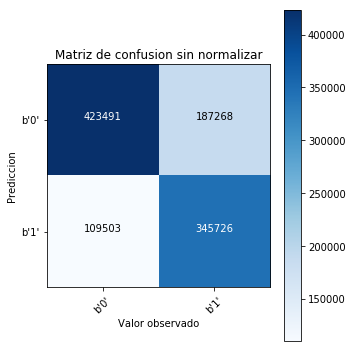

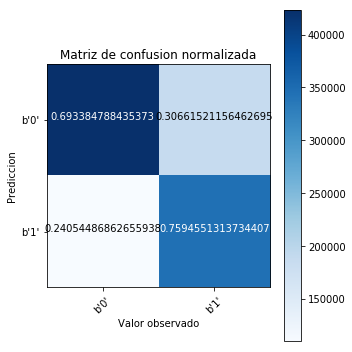

In [42]:
display(HTML("<h1>Matriz de confusión para el conjunto de entrenamiento</h1>"))

prediccionesXGB=(scoreXGB<=0.6)*0
prediccionesXGB=(scoreXGB>0.6)*1


# Compute Training confusion matrix
cnf_matrix = confusion_matrix(prediccionesXGB, y_train)
np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Matriz de confusion sin normalizar')

# Plot matriz de confusion normalizada
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Matriz de confusion normalizada')
plt.show()

from sklearn.metrics import accuracy_score
comentario="<h3>Accuracy = " + str(round(accuracy_score(y_train, (scoreXGB>0.6)*1, normalize=True),4))+"</h3>"
display(HTML(comentario))

Matriz de confusion sin normalizar
[[181489   9533]
 [ 47112  16111]]
Matriz de confusion normalizada
[[0.95 0.05]
 [0.75 0.25]]


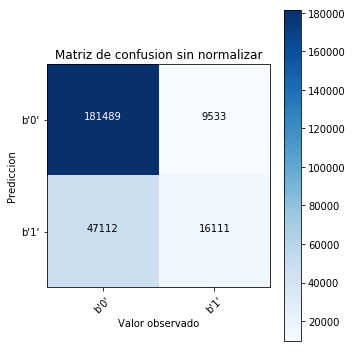

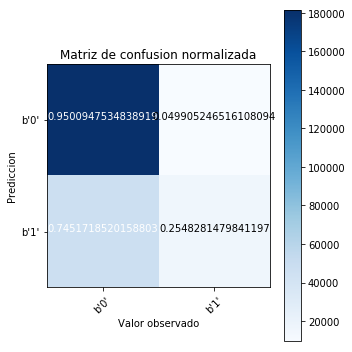

In [43]:
display(HTML("<h1>Matriz de confusión para el conjunto de testeo</h1>"))

prediccionesXGB_=(scoreXGB_<=0.6)*0
prediccionesXGB_=(scoreXGB_>0.6)*1

# Compute Testing confusion matrix
cnf_matrix = confusion_matrix(prediccionesXGB_, y_test)
np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
title='Matriz de confusion sin normalizar')
# Plot matriz de confusion normalizada
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
title='Matriz de confusion normalizada')
plt.show()
from sklearn.metrics import accuracy_score
comentario="<h3>Accuracy = " + str(round(accuracy_score(y_test, (scoreXGB_>0.6)*1, normalize=True),4))+"</h3>"
display(HTML(comentario))


# Curva ROC XGB empleando CV
Se genera la curva ROC para el training utilizando cross validation

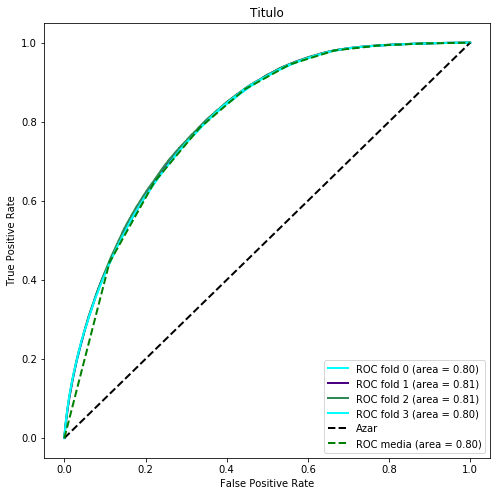

In [44]:
display(HTML("<h1>Curva ROC para el modelo XGBOOST (Fold=3)</h1>"))
#
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

plt.figure(figsize=(8,8))
# Corre el modelo con cross-validation y curva ROC
cv = StratifiedKFold(n_splits=4)
#classifier= debe ser el mejor modelo tuneado
classifier = XGBClassifier()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 10)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
colors = cycle(['cyan', 'indigo', 'seagreen'])
lw = 2
i = 0
for (train, test), color in zip(cv.split(X_train, y_train), colors):
    probas_ = classifier.fit(X_train.iloc[train,:], y_train[train]).predict_proba(X_train.iloc[test,:])
    # Calcula la curva ROC y area bajo la curva
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
    label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
label='Azar')
mean_tpr /= cv.get_n_splits(X_train, y_train)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
label='ROC media (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titulo')
plt.legend(loc="lower right")
plt.show()



Matriz de confusion sin normalizar
[[374020  12051]
 [201727  55979]]
Matriz de confusion normalizada
[[0.97 0.03]
 [0.78 0.22]]


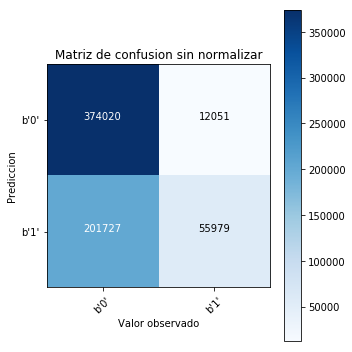

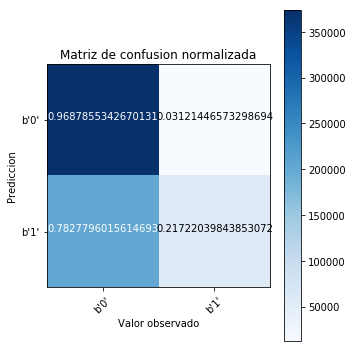

In [45]:
display(HTML("<h1>Matriz de confusión para el conjunto de backtesting</h1>"))
# Compute Testing confusion matrix
cnf_matrix = confusion_matrix(prediccionesXGB_Back, y_backtest)
np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
title='Matriz de confusion sin normalizar')
# Plot matriz de confusion normalizada
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
title='Matriz de confusion normalizada')
plt.show()
from sklearn.metrics import accuracy_score
comentario="<h3>Accuracy = " + str(round(accuracy_score(y_backtest, (scoreXGB_Back>0.6)*1, normalize=True),4))+"</h3>"
display(HTML(comentario))


# Importancia de variables XGB
Acá se ordenan las variables según la importancia de cada una de ellas y se dejan plasmadas en un gráfico.

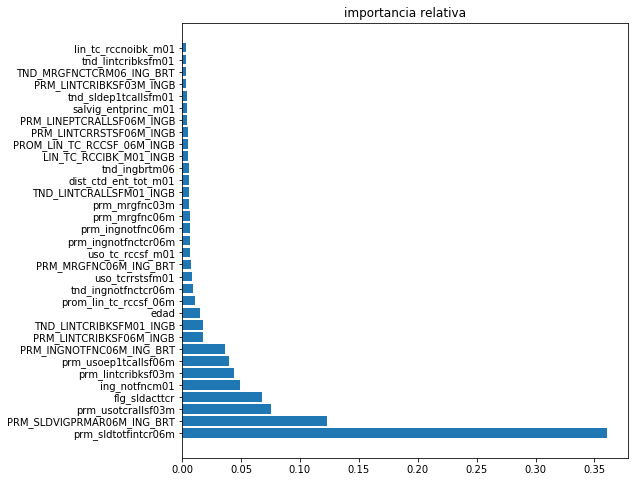

In [46]:
display(HTML("<h1>Importancia de las variables empeladas por el modelo</h1>"))
names=X_train.columns.values.tolist()#[importancesXGB>0.01] #nombres de las variables
importancesXGB = modelXGB.feature_importances_
importances=importancesXGB
%matplotlib inline
import matplotlib.pyplot as plt
nuevo=pd.DataFrame(names)
nuevo["variable"]=pd.DataFrame(names)
nuevo["importancia"]=importances
nuevo=nuevo[nuevo["importancia"]>0.003]
nuevo=nuevo.sort_values(['importancia'], ascending=[0])
plt.figure(figsize=(8,8))
plt.title("importancia relativa")
plt.barh(nuevo["variable"], nuevo["importancia"], align="center")
plt.rcParams['figure.figsize'] = [15,15]
plt.show()


In [47]:
nuevo
nuevo.to_csv('variables.csv', sep=",")

# Relacion entre variable importante y score por clase
Se genera un gráfico de puntos (scatter plot) en el que se observa la nube de puntos entre la variable respuesta y cada una de las variables, para ir seleccionando.

In [16]:
import ipywidgets as widgets

variable_E = widgets.Dropdown(
    options=nuevo["variable"],
    description='Number:',
    disabled=False,
)
display(HTML("<h3>Seleccione una variale para ver su relacion con el score por clase</h3>"), variable_E, 
       HTML("<h4>....y correr la siguiente celda</h4>"))


Dropdown(description='Number:', options=('prm_sldtotfintcr06m', 'PRM_SLDVIGPRMAR06M_ING_BRT', 'prm_usotcrallsf…

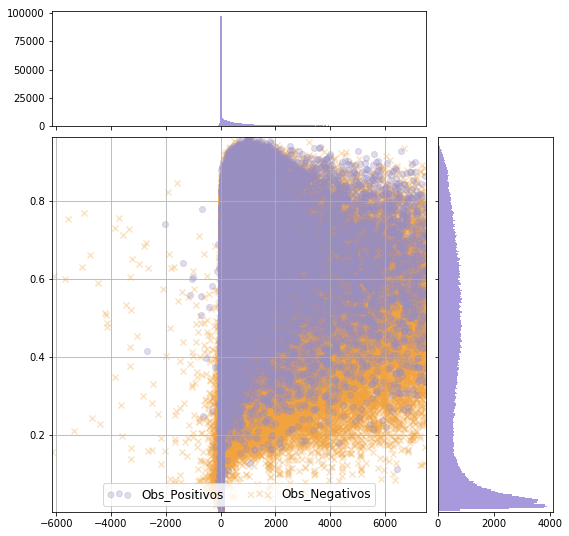

None

In [17]:
display(HTML("<h1>Análisis de las variables más importantes con respecto al score por clase</h1>"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

colors = ['#998ec3', '#f1a340']

#data
xx = X_test[variable_E.value]
media=np.mean(xx)
truess=((xx > -3*media) & (xx < 3*media)).values
xx=xx[truess]

yy = scoreXGB_[truess]
hh = y_test[truess]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:

li = axScatter.scatter(xx[hh==0], yy[hh==0], marker='x',  color=colors[1], alpha=.3)
lo = axScatter.scatter(xx[hh==1], yy[hh==1], marker='o', color=colors[0], alpha=0.3)
axScatter.set_xlim((np.min(xx), np.max(xx)))
axScatter.set_ylim((np.min(yy), np.max(yy)))

#binsx=np.percentile(xx, [10,20,30,40,50,60,70,80,90, 100])
#binsy = np.arange(np.min(y), np.max(y) , abs(np.min(y)- np.max(y))/20)
#binsy=np.percentile(yy, [10,20,30,40,50,60,70,80,90, 100])
binsx = np.arange(np.min(xx), np.max(xx) , abs(np.min(xx)- np.max(xx))/300)
binsy = np.arange(np.min(yy), np.max(yy) , abs(np.min(yy)- np.max(yy))/300)
axHistx.hist(xx, bins=binsx, color='#2300A8', alpha=0.4)
axHisty.hist(yy, bins=binsy, orientation='horizontal', color='#2300A8', alpha=0.4)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.legend((lo, li), ('Obs_Positivos', 'Obs_Negativos'), scatterpoints=3, loc='lower center', ncol=2,  fontsize=12)
axScatter.grid(True)
display(plt.show())

In [18]:
nuevo["acumulado"]=nuevo["importancia"].cumsum()
nuevo=nuevo.reset_index(drop=True)
comentario1="""
<h1>Cuadro de importancia de las variables empeladas por el modelo</h1>
<p>variable = Nombre de la variable</p>
<p>vimportancia = cuanto aporta la variable al modelo</p>
<p>acumulado = cuanto acumulan las variables que mas colaboran al modelo</p>
"""
display(HTML(comentario1), nuevo)

,0,variable,importancia,acumulado
0,prm_sldtotfintcr06m,prm_sldtotfintcr06m,0.281372,0.281372
1,PRM_SLDVIGPRMAR06M_ING_BRT,PRM_SLDVIGPRMAR06M_ING_BRT,0.133485,0.414856
2,prm_usotcrallsf03m,prm_usotcrallsf03m,0.088238,0.503094
3,flg_sldacttcr,flg_sldacttcr,0.066437,0.569532
4,prm_lintcribksf03m,prm_lintcribksf03m,0.052511,0.622043
5,ing_notfncm01,ing_notfncm01,0.048773,0.670815
6,prm_usoep1tcallsf06m,prm_usoep1tcallsf06m,0.040804,0.711620
7,PRM_INGNOTFNC06M_ING_BRT,PRM_INGNOTFNC06M_ING_BRT,0.032649,0.744269
8,codmes,codmes,0.031081,0.775350
9,TND_LINTCRIBKSFM01_INGB,TND_LINTCRIBKSFM01_INGB,0.020780,0.796130


<h1 style= color:red>Funcion para armar el KS:</h1>
<p>Esta es una función creada para armar la tabla KS.</p>
<p>En la misma puede observarse como se comprta el modelo para cada rango de score.</p>
<p>también se presenta un slider para determinar la cantidad de rangos a mostrar. (valor por defecto = 10)</p>
<h3>Hay que correr el siguiente código para usar en las siguientes celdas</h3>

In [19]:
def pivot2(predicciones, aciertos, score, cortes):
    data=pd.DataFrame(score)
    data["pred"]=predicciones
    data["orden"]=pd.qcut(score, cortes)
    #data["acierto"]=predicciones
    data["acierto"]=aciertos.values

    #pivot=pd.DataFrame(pd.pivot_table(data, values=['acierto'], rows=['orden'], cols=['target_pp'], aggfunc=sum, fill_value=0))
    pivot=pd.crosstab(data["orden"], data["acierto"])
    pivot.columns=["error","acierto"]
    tot1=sum(pivot["error"])
    tot2=sum(pivot["acierto"])

    pivot["mal"]=pivot.iloc[:,0]/(tot1*1.0)
    pivot["bien"]=pivot.iloc[:,1]/(tot2*1.0)
    #pivot=pivot.sort_values(['bien'], ascending=[0])
    #pivot=pivot.sort(['bien'], ascending=[0])
    pivot["cum_mal"]=np.cumsum(pivot["mal"]*1.0)
    pivot["cum_bien"]=np.cumsum(pivot["bien"])
    pivot["diferencia"]=(pivot["cum_bien"] - pivot["cum_mal"])*1
    maxKs=max((pivot["cum_bien"] - pivot["cum_mal"]))
    gini= 1-sum((slider1.value)**(-1)*(pivot["acierto"]/tot2))
    return (pivot.round(3), maxKs, gini)

slider1=widgets.IntSlider(value=10, min=5, max=30, step=1, description='Cortes', disabled=False, continuous_update=False,
    orientation='horizontal', readout=True, readout_format='d')
ff = """
<h1>Puntos de separacion tabla KS</h1>
<p>Seleccione la cantidad de cortes para visualizar la tabla.</p>
"""
display(HTML(ff), slider1)

IntSlider(value=10, continuous_update=False, description='Cortes', max=30, min=5)

In [20]:
pivot, ks, gini=pivot2(prediccionesXGB, aciertosXGB, scoreXGB, slider1.value)
display(HTML("<h1>Cuadro KS para el conjunto de entrenamiento</h1>"), pivot)
comentario="<h5>"+"En el training el valor de KS es igual a: "+str(round(ks,3)*100) +"</h5>"
display(HTML(comentario))

,error,acierto,mal,bien,cum_mal,cum_bien,diferencia
orden,,,,,,,
"(0.00255, 0.0543]",2192,104407,0.008,0.132,0.008,0.132,0.125
"(0.0543, 0.203]",11661,94938,0.042,0.120,0.050,0.253,0.203
"(0.203, 0.37]",28833,77766,0.104,0.099,0.154,0.352,0.198
"(0.37, 0.471]",43635,62963,0.157,0.080,0.311,0.431,0.121
"(0.471, 0.549]",50392,56207,0.181,0.071,0.492,0.503,0.011
"(0.549, 0.619]",43427,63177,0.156,0.080,0.648,0.583,-0.065
"(0.619, 0.685]",35598,71002,0.128,0.090,0.777,0.673,-0.103
"(0.685, 0.754]",28446,78151,0.102,0.099,0.879,0.772,-0.107
"(0.754, 0.832]",21264,85330,0.077,0.108,0.955,0.880,-0.075


In [21]:
pivot, ks, gini=pivot2(prediccionesXGB_, aciertosXGB_, scoreXGB_, slider1.value)
display(HTML("<h1>Cuadro KS para el conjunto de testeo</h1>"), pivot)
comentario="<h5>"+"En el training el valor de KS es igual a: "+str(round(ks,3)*100) +"</h5>"
display(HTML(comentario))

,error,acierto,mal,bien,cum_mal,cum_bien,diferencia
orden,,,,,,,
"(0.0033699999999999997, 0.0331]",41,25384,0.001,0.146,0.001,0.146,0.145
"(0.0331, 0.0643]",119,25305,0.001,0.145,0.002,0.291,0.289
"(0.0643, 0.148]",333,25092,0.004,0.144,0.006,0.435,0.429
"(0.148, 0.285]",766,24658,0.010,0.141,0.016,0.576,0.561
"(0.285, 0.393]",1407,24018,0.018,0.138,0.033,0.714,0.681
"(0.393, 0.478]",2052,23372,0.026,0.134,0.059,0.848,0.789
"(0.478, 0.558]",17022,8402,0.213,0.048,0.272,0.896,0.624
"(0.558, 0.641]",21487,3938,0.269,0.023,0.541,0.919,0.378
"(0.641, 0.742]",20259,5165,0.253,0.030,0.794,0.949,0.155


#--------------------------------------------------------------------------------------------------------------

#Guardamos el modelo
En caso de que estemos satisfechos con los valores del modelo, se pasa a dejar guardado el mismo a los fines de poder scorear en un futuro

In [48]:
from sklearn.externals import joblib
joblib.dump(modelXGB, 'xgb_model_il_final.pkl', compress=True)

['xgb_model_il_final.pkl']

#Cargamos el dataset a aplicar
Luego empieza todo el código para aplicar el modelo y generar los grupos de ejecución a los fines de que quede todo establecido.

In [1]:
import boto3
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML

import numpy as np
import pandas as pd 


client = boto3.client('s3') 
#el csv que se pone en el key es el que proviene del archivo AWS_TABLON_SCORE_FINAL.txt
#recordar cambiar la fecha
obj= client.get_object(Bucket='sftp-analytics-stg-transferbucket-a3e4afdvn23', Key='data/output/Unsaved/2019/12/27/3e425336-1aef-48d2-82f7-b1cd5b3b2612.csv')
X_apli= pd.read_csv(obj['Body'])

codigo_cliente=X_apli["key_value"]

X_apli = X_apli.apply(pd.to_numeric, errors='coerce')

numerics=["int16", "int32", "int64", "float16", "float32", "float64"]
X_apli=X_apli.select_dtypes(include=numerics)
#X = X.drop(["flg_Venta", "flag_incrementa_consumo", "flg_Campania", "parquetarcred", "pa",
#            "flg_Venta_ing", "flg_Campania_ing", "parquetarcred_ing", "pa_ing",
#           "segmentomercado_ing", "Tend_ingresobruto_ing", "segmento_ant_ing", "codempresa_tc_princ_ing", "codsbs_ing"],axis=1)



#codigo_cliente=X_apli["key_value"]

X_apli= X_apli.apply(pd.to_numeric, errors='coerce')

X_apli[np.isnan(X_apli)] = 0


print (np.shape(X_apli))

print (np.shape(codigo_cliente))


(273079, 51)
(273079,)


In [2]:
print(X_apli)


        codmes  key_value  edad  flg_sldacttcr  ing_notfncm01  prm_mrgfnc03m  \
0       202001        0.0  47.0            1.0           16.0          5.973   
1       202001        0.0  27.0            1.0            0.0         69.213   
2       202001        0.0  61.0            1.0            0.0        -27.900   
3       202001        0.0  53.0            1.0            0.0         -8.377   
4       202001        0.0  43.0            0.0            0.0          0.000   
...        ...        ...   ...            ...            ...            ...   
273074  202001        0.0  44.0            1.0            0.0          0.000   
273075  202001        0.0  55.0            1.0            0.0         26.740   
273076  202001        0.0  53.0            1.0           10.0        -23.553   
273077  202001        0.0  55.0            1.0            0.0          0.010   
273078  202001        0.0  26.0            1.0            0.0          0.400   

        prm_ingnotfnc06m  prm_ingnotfnc

In [3]:
print(codigo_cliente)

0         2C77D09B3A3BBD480B86627F06EF89B12F6D612174593E...
1         F741B217403C588A9B14BDC189083800BD8945AD1DA01B...
2         9C309B3AD0E61EA3281D1D89AF3E2C38A1B638C013B61D...
3         4F8E7F5AE5FA55C85AE0D89057B63B4D96EFA5578C8669...
4         3066DF3F248C00876018C557D8BD197162D55FB888DA76...
                                ...                        
273074    17E5371AA47EB68FD09043BD90FC9917FEC0015015654A...
273075    0B9B62C771A419B3016A11713C0C96E85DB469191083DB...
273076    F838626B9B3295C251CA89A6B7BE65376D7DC55AF6B08C...
273077    C4F9A7070D30971EA06CAF2845AA78A709B1E1EF4EFB42...
273078    BCD23250C277931FBB7EB951F55A4BC3D08C8700FF72BE...
Name: key_value, Length: 273079, dtype: object


In [4]:
X_apli = X_apli.drop(["codmes"],axis=1)

In [5]:
# Cargo los modelos guardados

In [5]:
#from sklearn.externals import joblib
import joblib

xgb_Model = joblib.load('xgb_model_il_final.pkl')
codmes=202001

# Aplico al modelo guardado a los datos
scoreXGB=xgb_Model.predict_proba(X_apli)[:,1]
guardo_score={"key_value":codigo_cliente, "Periodo": codmes, "Score_XGB":scoreXGB}
guardo_score=pd.DataFrame(guardo_score)

np.shape(guardo_score)

guardo_score=guardo_score.replace('"','', regex=True)

print(guardo_score)


                                                key_value  Periodo  Score_XGB
0       2C77D09B3A3BBD480B86627F06EF89B12F6D612174593E...   202001   0.215338
1       F741B217403C588A9B14BDC189083800BD8945AD1DA01B...   202001   0.727522
2       9C309B3AD0E61EA3281D1D89AF3E2C38A1B638C013B61D...   202001   0.309447
3       4F8E7F5AE5FA55C85AE0D89057B63B4D96EFA5578C8669...   202001   0.220372
4       3066DF3F248C00876018C557D8BD197162D55FB888DA76...   202001   0.024145
...                                                   ...      ...        ...
273074  17E5371AA47EB68FD09043BD90FC9917FEC0015015654A...   202001   0.253491
273075  0B9B62C771A419B3016A11713C0C96E85DB469191083DB...   202001   0.255698
273076  F838626B9B3295C251CA89A6B7BE65376D7DC55AF6B08C...   202001   0.544285
273077  C4F9A7070D30971EA06CAF2845AA78A709B1E1EF4EFB42...   202001   0.182497
273078  BCD23250C277931FBB7EB951F55A4BC3D08C8700FF72BE...   202001   0.445936

[273079 rows x 3 columns]


In [6]:
import numpy as np
import pandas as pd 
from io import BytesIO
#from sklearn.externals import joblib
import joblib

xgb_Model = joblib.load('xgb_model_il_final.pkl')

## el csv que se pone acá es el que viene de la in_riesgos con frescura y contacto
##Recordar cambiar la fecha
obj= client.get_object(Bucket='sftp-analytics-stg-transferbucket-a3e4afdvn23', Key='data/output/Unsaved/2019/12/27/90778fd6-e442-497b-a5b0-5e6ad38faaab.csv')
X_frescura= pd.read_csv(obj['Body'])

print (np.shape(X_frescura))

print(X_frescura)


(273079, 9)
        codmes  codunicocli  \
0       202001     12260250   
1       202001     12048720   
2       202001     14511508   
3       202001      9386295   
4       202001     10573720   
...        ...          ...   
273074  202001     16129150   
273075  202001     12625027   
273076  202001     16270622   
273077  202001     14986940   
273078  202001     14535706   

                                                key_value  mtolineatotal_1  \
0       F5472E530BB9594ECA3948F676867C6B920AD59CFE7BEA...             5700   
1       C968C6641C9E963B188E7FC2B1FE832638D1806748BDA2...             7500   
2       CC5DAB07B0322B1406CB5F987D26D516EEC08D6BB400C1...             6700   
3       2C9AAC771F70FA492D0EDA6A962888B3E8226041E7B919...             7700   
4       4697DF4E424FABCD079F4CFAF15283410D55BE1386BE40...             1900   
...                                                   ...              ...   
273074  233E8C56101AC523676B771500A96EDA93A52706F1CB40...            

In [7]:
guardo_score.set_index('key_value')

X_frescura.set_index('key_value')


base_score_total = pd.merge(left=guardo_score,right=X_frescura,how='inner', left_on='key_value', right_on='key_value')

print (np.shape(base_score_total))

(273079, 11)


In [8]:
print(base_score_total)

                                                key_value  Periodo  Score_XGB  \
0       2C77D09B3A3BBD480B86627F06EF89B12F6D612174593E...   202001   0.215338   
1       F741B217403C588A9B14BDC189083800BD8945AD1DA01B...   202001   0.727522   
2       9C309B3AD0E61EA3281D1D89AF3E2C38A1B638C013B61D...   202001   0.309447   
3       4F8E7F5AE5FA55C85AE0D89057B63B4D96EFA5578C8669...   202001   0.220372   
4       3066DF3F248C00876018C557D8BD197162D55FB888DA76...   202001   0.024145   
...                                                   ...      ...        ...   
273074  17E5371AA47EB68FD09043BD90FC9917FEC0015015654A...   202001   0.253491   
273075  0B9B62C771A419B3016A11713C0C96E85DB469191083DB...   202001   0.255698   
273076  F838626B9B3295C251CA89A6B7BE65376D7DC55AF6B08C...   202001   0.544285   
273077  C4F9A7070D30971EA06CAF2845AA78A709B1E1EF4EFB42...   202001   0.182497   
273078  BCD23250C277931FBB7EB951F55A4BC3D08C8700FF72BE...   202001   0.445936   

        codmes  codunicocli

In [9]:
base_score_total['Decile_score']=pd.qcut(base_score_total['Score_XGB'],10,labels=False)

In [10]:
base_score_total['grupo_ejecucion'] = np.select([((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='RECOMENDADO')
                                                |(base_score_total['score_contact']=='ALTO')) & (base_score_total['Score_XGB']>=0.62),

                                            ((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='RECOMENDADO')
                                                |(base_score_total['score_contact']=='ALTO')) & (base_score_total['Score_XGB']>=0.35) 
                                               & (base_score_total['Score_XGB']<0.62),

                                                 ((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='MEDIO'))
                                               & (base_score_total['Score_XGB']>=0.52),

                                                 ((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='MEDIO') |
                                                (base_score_total['score_contact']=='BAJO') | (base_score_total['score_contact']=='PERDIDA')
                                                | (base_score_total['score_contact']=='')) & (base_score_total['Score_XGB']>=0.3) & (base_score_total['Score_XGB']<0.52),

                                                ((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='RECOMENDADO')
                                                |(base_score_total['score_contact']=='ALTO')) & (base_score_total['Score_XGB']<0.35),

                                               ((base_score_total['grupo_frescura']=='G1') | (base_score_total['grupo_frescura']=='G2') | 
                                               (base_score_total['grupo_frescura']=='G3')) & ((base_score_total['score_contact']=='MEDIO') |
                                                (base_score_total['score_contact']=='BAJO') | (base_score_total['score_contact']=='PERDIDA')
                                                | (base_score_total['score_contact']=='')) & (base_score_total['Score_XGB']<0.3)],

                                                ['grupo_1','grupo_2','grupo_3','grupo_4','grupo_5','grupo_6'],default='grupo_7')

base_score_total.to_csv('score_aplicado_202001_1_Frank_prueba.csv', sep=",")

###donde guardamos los resultados de S3?


In [11]:
base_score_total[base_score_total.duplicated(['key_value'])]

,key_value,Periodo,Score_XGB,codmes,codunicocli,mtolineatotal_1,incremento,linea_nueva_cuenta,prob_contact,score_contact,grupo_frescura,Decile_score,grupo_ejecucion


In [12]:
base_score_total.head()

,key_value,Periodo,Score_XGB,codmes,codunicocli,mtolineatotal_1,incremento,linea_nueva_cuenta,prob_contact,score_contact,grupo_frescura,Decile_score,grupo_ejecucion
0,2C77D09B3A3BBD480B86627F06EF89B12F6D612174593E...,202001,0.215338,202001,8752194,26200,21900,48100,0.088758,MEDIO,G1,3,grupo_6
1,F741B217403C588A9B14BDC189083800BD8945AD1DA01B...,202001,0.727522,202001,14666155,900,6800,7700,0.369061,RECOMENDADO,G2,9,grupo_1
2,9C309B3AD0E61EA3281D1D89AF3E2C38A1B638C013B61D...,202001,0.309447,202001,9501381,4000,900,4900,0.540059,RECOMENDADO,G3,4,grupo_5
3,4F8E7F5AE5FA55C85AE0D89057B63B4D96EFA5578C8669...,202001,0.220372,202001,14701485,2000,8000,10000,0.371868,RECOMENDADO,G4,3,grupo_7
4,3066DF3F248C00876018C557D8BD197162D55FB888DA76...,202001,0.024145,202001,13369635,4700,1000,5700,0.046969,BAJO,G4,0,grupo_7


In [13]:
base_score_total.size

3421639